# Amazon_Reviews_Analysis_NLP


### (Main aim: Practice Document Clustering and Topic Modeling) 
##### Jason Wu 2022/08/20

# intro

Nowadays, Natural Language Processing is a hot and trending topic. Analyzing the text is crucial in many industries. In E-commence, for example, analyzing product reviews can help the company to cluster different types of customers, and thus the companies can recommend corresponding products to increase revenue.  Because of the importance of NLP, in this project, I choose a dataset containing Amazon Watch reviews to analyze whether there is any pattern that exists for the customers. I use unsupervised learning models to cluster unlabeled documents into different groups, visualize the results and identify their latent topics/structures.

The original dataset is from here: [Dataset information](https://snap.stanford.edu/data/web-Amazon.html)

## Contents

* [Part 1: Load Data](#Part-1:-Load-Data)
* [Part 2: Tokenizing and Stemming](#Part-2:-Tokenizing-and-Stemming)
* [Part 3: TF-IDF](#Part-3:-TF-IDF)
* [Part 4: K-means clustering](#Part-4:-K-means-clustering)
* [Part 5: Topic Modeling - Latent Dirichlet Allocation](#Part-5:-Topic-Modeling---Latent-Dirichlet-Allocation)


# Part 0: Setup Google Drive Environment

In [ ]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Part 1: Load Data

In [ ]:
import numpy as np
import pandas as pd
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Load data into dataframe

file = drive.CreateFile({'id':'17zlbpvbVQ0cQyZ7cA4XYFoMNIIt-RgEu'}) # replace the id with id of file you want to access
file.GetContentFile('data.tsv')  # tab-separated
df = pd.read_csv('data.tsv', sep='\t', error_bad_lines=False) 

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
b'Skipping line 8704: expected 15 fields, saw 22\nSkipping line 16933: expected 15 fields, saw 22\nSkipping line 23726: expected 15 fields, saw 22\n'
b'Skipping line 85637: expected 15 fields, saw 22\n'
b'Skipping line 132136: expected 15 fields, saw 22\nSkipping line 158070: expected 15 fields, saw 22\nSkipping line 166007: expected 15 fields, saw 22\nSkipping line 171877: expected 15 fields, saw 22\nSkipping line 177756: expected 15 fields, saw 22\nSkipping line 181773: expected 15 fields, saw 22\nSkipping line 191085: expected 15 fields, saw 22\nSkipping line 196273: expected 15 fields, saw 22\nSkipping line 196331: expected 15 fields, saw 22\n'
b'Skipping line 197000: expected 15 fields, saw 22\nSkipping line 197011: expected 15 fields, saw 22\nSkip

In [ ]:
# Remove missing value 
df.dropna(subset=['review_body'],inplace=True) #inplace = True meaning that changing directly on the df
df.reset_index(inplace=True, drop=True) 
df.head(3)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,3653882,R3O9SGZBVQBV76,B00FALQ1ZC,937001370,"Invicta Women's 15150 ""Angel"" 18k Yellow Gold ...",Watches,5,0,0,N,Y,Five Stars,Absolutely love this watch! Get compliments al...,2015-08-31
1,US,14661224,RKH8BNC3L5DLF,B00D3RGO20,484010722,Kenneth Cole New York Women's KC4944 Automatic...,Watches,5,0,0,N,Y,I love thiswatch it keeps time wonderfully,I love this watch it keeps time wonderfully.,2015-08-31
2,US,27324930,R2HLE8WKZSU3NL,B00DKYC7TK,361166390,Ritche 22mm Black Stainless Steel Bracelet Wat...,Watches,2,1,1,N,Y,Two Stars,Scratches,2015-08-31


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960056 entries, 0 to 960055
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   marketplace        960056 non-null  object
 1   customer_id        960056 non-null  int64 
 2   review_id          960056 non-null  object
 3   product_id         960056 non-null  object
 4   product_parent     960056 non-null  int64 
 5   product_title      960054 non-null  object
 6   product_category   960056 non-null  object
 7   star_rating        960056 non-null  int64 
 8   helpful_votes      960056 non-null  int64 
 9   total_votes        960056 non-null  int64 
 10  vine               960056 non-null  object
 11  verified_purchase  960056 non-null  object
 12  review_headline    960049 non-null  object
 13  review_body        960056 non-null  object
 14  review_date        960052 non-null  object
dtypes: int64(5), object(10)
memory usage: 109.9+ MB


In [ ]:
# use the first 1000 review data as our training data for exploring (Note: it is ok to include all data but it is more time consuming, so for the time sake, for now we only include the first 1000 data)
data = df.loc[:999, 'review_body'].tolist()

# Part 2: Tokenizing and Stemming

Load stopwords and stemmer function from NLTK library.
Stop words are words like "a", "the", or "in" which don't convey significant meaning.
Stemming is the process of breaking a word down into its root.

In [ ]:
# Use nltk's English stopwords.
stopwords = nltk.corpus.stopwords.words('english') #stopwords.append("n't")
stopwords.append("'s")
stopwords.append("'m")
stopwords.append("br") #html <br>
stopwords.append("watch")

print ("We use " + str(len(stopwords)) + " stop-words from nltk library.")
print (stopwords[:10])

We use 183 stop-words from nltk library.
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


Use our defined functions to analyze (i.e. tokenize, stem) our reviews.

In [ ]:
from nltk.stem.snowball import SnowballStemmer
# from nltk.stem import WordNetLemmatizer 

stemmer = SnowballStemmer("english")

# tokenization and stemming
def tokenization_and_stemming(text):
    tokens = []
    # exclude stop words and tokenize the document, generate a list of string 
    for word in nltk.word_tokenize(text): #word_tokenize: split a sentence to single word and return a list 
        if word.lower() not in stopwords:
            tokens.append(word.lower())

    filtered_tokens = []
    
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if token.isalpha(): # isalpha() method returns True if all the characters are alphabet letters (a-z)
            filtered_tokens.append(token)
            
    # stemming
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [ ]:
tokenization_and_stemming(data[0])

['absolut',
 'love',
 'get',
 'compliment',
 'almost',
 'everi',
 'time',
 'wear',
 'dainti']

In [ ]:
data[0]

'Absolutely love this watch! Get compliments almost every time I wear it. Dainty.'

# Part 3: TF-IDF

TF: Term Frequency

IDF: Inverse Document Frequency

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# define vectorizer parameters
# TfidfVectorizer will help us to create tf-idf matrix
# max_df : maximum document frequency for the given word (If a word appears more than max_df value, then drop it)
# min_df : minimum document frequency for the given word (If a word appears less than min_df value, then drop it)
# max_features: maximum number of words (After calculating TFIDF, only keey features with Top 1000 highest TFIDF value)
# use_idf: if not true, we only calculate tf (but TFIDF is recommended)
# stop_words : built-in stop words
# tokenizer: how to tokenize the document
# ngram_range: (min_value, max_value), eg. (1, 3) means the result will include 1-gram, 2-gram, 3-gram
tfidf_model = TfidfVectorizer(max_df=0.99, max_features=1000,
                                 min_df=0.01, stop_words='english',
                                 use_idf=True, tokenizer=tokenization_and_stemming, ngram_range=(1,1))

tfidf_matrix = tfidf_model.fit_transform(data) #fit the vectorizer to synopses

print ("In total, there are " + str(tfidf_matrix.shape[0]) + \
      " reviews and " + str(tfidf_matrix.shape[1]) + " terms.")

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['afterward', 'alon', 'alreadi', 'alway', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becom', 'besid', 'cri', 'describ', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'otherwis', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev'] not in stop_words.
  % sorted(inconsistent)


In total, there are 1000 reviews and 239 terms.


In [ ]:
tfidf_matrix

<1000x239 sparse matrix of type '<class 'numpy.float64'>'
	with 6891 stored elements in Compressed Sparse Row format>

In [ ]:
tfidf_matrix.toarray() #toarray return a ndarray

array([[0.       , 0.5125863, 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]])

In [ ]:
tfidf_matrix.todense() #todense return a matrix

matrix([[0.       , 0.5125863, 0.       , ..., 0.       , 0.       ,
         0.       ],
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        ...,
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ]])

In [ ]:
print(type(tfidf_matrix.toarray()))

<class 'numpy.ndarray'>


In [ ]:
print(type(tfidf_matrix.todense()))

<class 'numpy.matrix'>


Save the terms identified by TF-IDF.

In [ ]:
# words
tf_selected_words = tfidf_model.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
tf_selected_words[:5] # give us the TFIDF martix's corresbonding word's name --> useful for later analysis process

['abl', 'absolut', 'accur', 'actual', 'adjust']

In [ ]:
# check the length of tf_selected_words
len(tf_selected_words)

239

# Part 4: K-means clustering

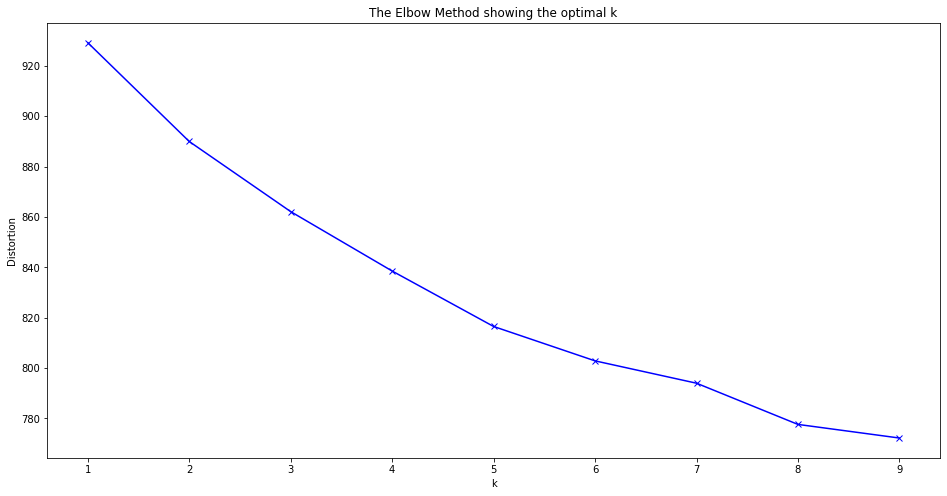

In [ ]:
#elbow method to find the optimal k 
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(tfidf_matrix)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
# base on the elbow method, it is a little bit hard to determine as the line is smooth, but k = 5 seems a rational choice 
num_clusters = 5

# number of clusters
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

In [ ]:
clusters[:10] # this our predicted cluster for each review

[3, 3, 0, 0, 0, 3, 1, 0, 1, 0]

## 4.1. Analyze K-means Result

In [ ]:
# create DataFrame films from all of the input files.
product = { 'review': df[:1000].review_body, 'cluster': clusters}
frame = pd.DataFrame(product, columns = ['review', 'cluster'])

In [ ]:
frame.head(10)

,review,cluster
0,Absolutely love this watch! Get compliments al...,3
1,I love this watch it keeps time wonderfully.,3
2,Scratches,0
3,"It works well on me. However, I found cheaper ...",0
4,Beautiful watch face. The band looks nice all...,0
5,"i love this watch for my purpose, about the pe...",3
6,"for my wife and she loved it, looks great and ...",1
7,I was about to buy this thinking it was a Swis...,0
8,Watch is perfect. Rugged with the metal &#34;B...,1
9,Great quality and build.<br />The motors are r...,0


In [ ]:
print ("Number of reviews included in each cluster:")
frame['cluster'].value_counts().to_frame()   #K-mean led to a unbalanced cluster, and this indicates a disadvantages of K means 

Number of reviews included in each cluster:


,cluster
0,664
3,108
1,91
4,75
2,62


In [ ]:
km.cluster_centers_ 
# K means cluster_centers_ is the point that are most representative for the cluster 
# The word with higher TFIDF can be more representative than one with a lower TFIDF
# Thus, I subsequently choose the top 6 words (word with Top 6 TFIDF value) to be the key word represent the cluster 

array([[0.00568198, 0.00439149, 0.00384602, ..., 0.00656059, 0.01809168,
        0.0138699 ],
       [0.00354386, 0.        , 0.        , ..., 0.00244915, 0.        ,
        0.02135392],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00784247,
        0.        ],
       [0.        , 0.04240567, 0.        , ..., 0.01256107, 0.01765257,
        0.00411372],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00874405,
        0.        ]])

In [ ]:
km.cluster_centers_.shape

(5, 239)

In [ ]:
order_centroids = km.cluster_centers_.argsort()[:, ::-1] #argsort: return the original index of the sorted list (list[90] > list[159])   [:, ::-1] : copy array, before comma: filter row, after comma: filter col
order_centroids

array([[118, 114, 234, ...,  30, 171, 199],
       [ 92, 118, 157, ..., 180, 179, 146],
       [132, 157, 118, ..., 142, 141,   0],
       [120, 231, 118, ..., 155, 154,   0],
       [ 90, 159, 157, ..., 144, 143,   0]])

In [ ]:
", ".join(cluster_reviews[0:3])

"very good, It's a good value, and a good functional watch strap.  It's super wide though, and takes more space on the wrist than I'd like., very good"

In [ ]:
print ("<Document clustering result by K-means>")

#km.cluster_centers_ denotes the importances of each items in centroid.
#We need to sort it in decreasing-order and get the top k items.
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
Cluster_keywords_summary = {}
for i in range(num_clusters):
    print ("Cluster " + str(i) + " words:", end='')
    Cluster_keywords_summary[i] = []
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        Cluster_keywords_summary[i].append(tf_selected_words[ind]) #tf_selected_word is the list where I split it previously, it contains TFIDF martix's corresbonding word's name
        print (tf_selected_words[ind] + ",", end='')
    print ()
    
    cluster_reviews = frame[frame.cluster==i].review.tolist()
    print ("Cluster " + str(i) + " reviews (" + str(len(cluster_reviews)) + " reviews)")
    print("Here are three sample reviews: ")
    print (", ".join(cluster_reviews[0:3]))
    print ()

<Document clustering result by K-means>
Cluster 0 words:look,like,work,band,time,beauti,
Cluster 0 reviews (664 reviews)
Here are three sample reviews: 
Scratches, It works well on me. However, I found cheaper prices in other places after making the purchase, Beautiful watch face.  The band looks nice all around.  The links do make that squeaky cheapo noise when you swing it back and forth on your wrist which can be embarrassing in front of watch enthusiasts.  However, to the naked eye from afar, you can't tell the links are cheap or folded because it is well polished and brushed and the folds are pretty tight for the most part.<br /><br />I love the new member of my collection and it looks great.  I've had it for about a week and so far it has kept good time despite day 1 which is typical of a new mechanical watch

Cluster 1 words:great,look,price,work,comfort,product,
Cluster 1 reviews (91 reviews)
Here are three sample reviews: 
for my wife and she loved it, looks great and a great 

# Part 5: Topic Modeling - Latent Dirichlet Allocation

In [ ]:
# Use LDA for clustering
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=5) #This number can be changed, for now I assume there are approximately 5 topics

In [ ]:
tfidf_matrix.shape

(1000, 239)

In [ ]:
# document topic matrix for tfidf_matrix_lda
lda_output = lda.fit_transform(tfidf_matrix)
print(lda_output.shape)
print(lda_output)

(1000, 5)
[[0.2642381  0.05933252 0.55316347 0.05939408 0.06387182]
 [0.08562223 0.08334166 0.66297913 0.08344178 0.08461521]
 [0.2        0.2        0.2        0.2        0.2       ]
 ...
 [0.10015473 0.10000031 0.5998441  0.10000059 0.10000027]
 [0.0671726  0.06863241 0.06973522 0.72734184 0.06711793]
 [0.07040395 0.18730849 0.06837364 0.07678084 0.59713308]]


In [ ]:
# topics and words matrix
topic_word = lda.components_
print(topic_word.shape)
print(topic_word)

(5, 239)
[[2.91386376 0.20133681 0.57651097 ... 3.02492444 9.68684989 8.35639848]
 [0.20010369 0.20347431 0.20190252 ... 0.20219154 2.54251533 0.20016147]
 [0.20007608 1.6803471  0.20107069 ... 2.25621823 0.20111212 2.10378775]
 [1.57952347 0.20112409 0.20141898 ... 0.20289227 0.20132856 0.20779046]
 [0.20176007 6.20948052 2.37285192 ... 1.24947082 3.4295819  1.72896731]]


In [ ]:
#Check the connection between topic and document

# column names
topic_names = ["Topic" + str(i) for i in range(lda.n_components)]

# index names
doc_names = ["Doc" + str(i) for i in range(len(data))]

df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topic_names, index=doc_names)

# get dominant topic for each document
topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['topic'] = topic

df_document_topic.head(10)

,Topic0,Topic1,Topic2,Topic3,Topic4,topic
Doc0,0.26,0.06,0.55,0.06,0.06,2
Doc1,0.09,0.08,0.66,0.08,0.08,2
Doc2,0.20,0.20,0.20,0.20,0.20,0
Doc3,0.76,0.06,0.06,0.06,0.06,0
Doc4,0.84,0.04,0.04,0.04,0.04,0
Doc5,0.07,0.07,0.70,0.07,0.07,2
Doc6,0.06,0.40,0.07,0.41,0.06,3
Doc7,0.06,0.06,0.40,0.41,0.06,3
Doc8,0.82,0.05,0.04,0.05,0.05,0
Doc9,0.06,0.10,0.06,0.73,0.06,3


In [ ]:
df_document_topic['topic'].value_counts().to_frame() #LDA give us a much balanced clustering result than K means

,topic
0,331
2,184
3,178
4,163
1,144


In [ ]:
#Check the relationship between word and topic

# topic word matrix
print(lda.components_) #shape 5*239
# topic-word matrix
df_topic_words = pd.DataFrame(lda.components_)

# column and index
df_topic_words.columns = tfidf_model.get_feature_names()
df_topic_words.index = topic_names

df_topic_words.head() #weight: higher the weight, the word has more importance 

[[2.91386376 0.20133681 0.57651097 ... 3.02492444 9.68684989 8.35639848]
 [0.20010369 0.20347431 0.20190252 ... 0.20219154 2.54251533 0.20016147]
 [0.20007608 1.6803471  0.20107069 ... 2.25621823 0.20111212 2.10378775]
 [1.57952347 0.20112409 0.20141898 ... 0.20289227 0.20132856 0.20779046]
 [0.20176007 6.20948052 2.37285192 ... 1.24947082 3.4295819  1.72896731]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,abl,absolut,accur,actual,adjust,alarm,alreadi,alway,amaz,amazon,...,weight,went,wife,wind,wish,work,worn,worth,wrist,year
Topic0,2.913864,0.201337,0.576511,3.144077,2.047502,1.276350,1.621891,0.353421,0.394748,1.641305,...,4.317084,2.249807,0.203350,3.423026,3.765910,8.715316,3.401051,3.024924,9.686850,8.356398
Topic1,0.200104,0.203474,0.201903,0.203310,0.749274,1.177660,0.200508,0.202452,7.519774,0.204335,...,0.800505,0.200065,11.570005,0.201775,0.200185,2.897834,0.200162,0.202192,2.542515,0.200161
Topic2,0.200076,1.680347,0.201071,0.200074,0.200885,0.974058,0.252695,1.414483,2.450250,0.204955,...,0.200044,0.200049,0.200102,0.202719,0.200707,22.567820,0.200051,2.256218,0.201112,2.103788
Topic3,1.579523,0.201124,0.201419,0.201479,0.201918,0.200078,0.200418,2.563089,0.201025,2.733708,...,0.200479,0.865169,0.201557,0.203625,0.201083,6.677543,0.200281,0.202892,0.201329,0.207790
Topic4,0.201760,6.209481,2.372852,2.107456,3.093592,2.312263,3.487856,0.306557,0.203038,2.018237,...,0.200251,0.202084,0.467384,0.202564,0.202624,0.203154,0.201548,1.249471,3.429582,1.728967


In [ ]:
# print top n keywords for each topic
def print_topic_words(tfidf_model, lda_model, n_words):
    words = np.array(tfidf_model.get_feature_names())
    topic_words = []
    # for each topic, we have words weight
    for topic_words_weights in lda_model.components_:
        top_words = topic_words_weights.argsort()[::-1][:n_words]
        topic_words.append(words.take(top_words))
    return topic_words

topic_keywords = print_topic_words(tfidf_model=tfidf_model, lda_model=lda, n_words=15)        

df_topic_words = pd.DataFrame(topic_keywords)
df_topic_words.columns = ['Word '+str(i) for i in range(df_topic_words.shape[1])]
df_topic_words.index = ['Topic '+str(i) for i in range(df_topic_words.shape[0])]
df_topic_words

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,band,look,time,like,fit,light,great,strap,color,watch,wrist,make,love,wear,leather
Topic 1,nice,like,perfect,realli,wife,love,look,gift,amaz,big,super,price,happi,fine,bought
Topic 2,good,love,work,qualiti,buy,broke,pretti,use,pictur,time,husband,week,better,water,stop
Topic 3,great,product,look,awesom,price,fast,excel,ship,recommend,pleas,deliveri,qualiti,exact,want,work
Topic 4,beauti,expect,excel,larg,love,face,easi,littl,wear,read,comfort,color,time,absolut,band


### LDA conclusion: 
LDA teach us two important tables: 
1. which review belongs to which topic
2. which are the top importance words for each topic

# project Conclusion:

### As this is an unsupervised machine learning projects, the results can be interpreted in many different ways. Below is a brief analysis:

### In the K-means clustering, I supresingly find that the the top 6 important word in cluster 3 contains both "wife" and "husband". This indicates that there is a high chance indicating that people in this cluster love to buy products for their lovers. Therefore, Amazon can try to recommend flowers or related products to them during Festivals.

### For LDA, in topic 1, I find the top three words are "nice", "like", "perfect". This indicates that this cluster has a higher chance contains user that love this Watch. Hence, the Amazon can try to recommend them the product with the same brand. 